# IMDB Review Sentiment Analysis


Data source: https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format

Code adapted from: https://www.kaggle.com/code/miladlink/imdb-sentiment-analysis-pytorch

In [1]:
#!conda install -c conda-forge spacy
#or
#!pip install -U pip setuptools wheel
#!pip install -U spacy

#then
#!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz

import os, sys, re
import time
import copy
import pickle
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer

from models import LSTM, GRU, AttentionLSTM, Transformer

import spacy
# setup
NLP = spacy.load('en_core_web_sm')  # NLP toolkit

In [2]:
path = os.path.abspath(os.getcwd())
path_para = path+'/para'
if not os.path.exists(path_para):
    os.makedirs(path_para)

In [3]:
#initialize for random seeds/states
seeds=[12345,42,42]
def randomize(seed_rng=seeds[0], seed_np=seeds[1], seed_torch=seeds[2]):
    os.environ['PYTHONHASHSEED'] = '0'
    rng = np.random.default_rng(seed_rng)
    np.random.seed(seed_np)
    torch.manual_seed(seed_torch)

randomize()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Explore data

In [5]:
# Read dataset
train_df = pd.read_csv("data/Train.csv")
valid_df = pd.read_csv("data/Valid.csv")
test_df = pd.read_csv("data/Test.csv")

In [6]:
print('number of train:', len(train_df))
print('number of valid:', len(valid_df))
print('number of test:', len(test_df))
train_df.head(3)

number of train: 40000
number of valid: 5000
number of test: 5000


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0


/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

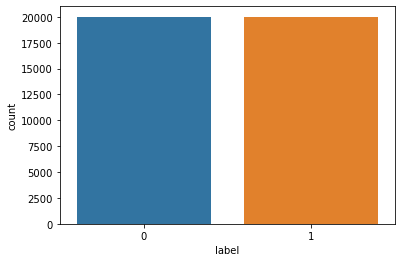

In [7]:
sns.countplot(train_df['label'])

/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

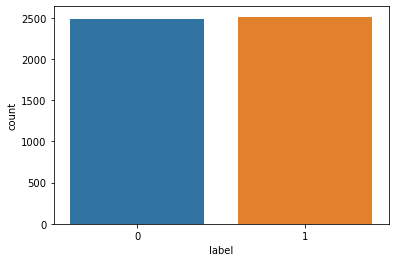

In [8]:
sns.countplot(valid_df['label'])

/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

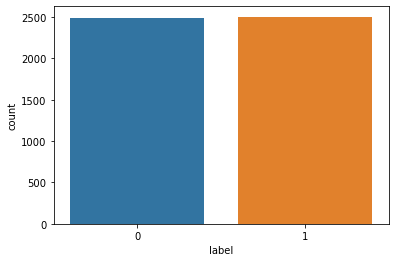

In [9]:
sns.countplot(test_df['label'])

In [10]:
num_words = [len(f.split(' ')) for f in train_df['text']]

# print statistics
print('Min length =', min(num_words))
print('Max length =', max(num_words))

print('Mean = {:.2f}'.format(np.mean(num_words)))
print('Std  = {:.2f}'.format(np.std(num_words)))

print('mean + 1 * sigma = {:.2f}'.format(np.mean(num_words) + 1.0 * np.std(num_words)))

Min length = 4
Max length = 2470
Mean = 231.33
Std  = 171.18
mean + 1 * sigma = 402.51


## Tokenize

In [11]:
use_stopwords = True
stopwords = NLP.Defaults.stop_words if use_stopwords else []
def tokenizer(text, stopwords=stopwords):
    text = re.sub(r"<br /><br />", " ", text)
    text = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’;]", " ", str(text))
    text = re.sub(r"[ ]+", " ", text)
    text = re.sub(r"\!+", "!", text)
    text = re.sub(r"\,+", ",", text)
    text = re.sub(r"\?+", "?", text)
    return [x.text for x in NLP.tokenizer(text) if x.text != " " and (x.text not in stopwords)]

In [12]:
print(stopwords)

{'somehow', '’m', 'put', 'this', 'although', 'how', 'as', 'elsewhere', 'fifty', 'anything', 'both', 'seem', 'anyone', 'few', 'but', "'ll", 'due', 'well', 'when', '‘re', 'same', 'always', 'thereby', 'thence', 'over', 'nevertheless', 'besides', 'forty', 'again', 'i', 'seeming', 'your', 'via', 'onto', 'nine', 'quite', 'only', 'must', 'the', 'get', 'least', 'less', 'until', 'regarding', 'our', 'afterwards', 'no', 'to', 'beside', '‘s', 'which', 'for', 'else', 'some', 'more', '‘ve', 'please', 'nothing', 'whereby', 'am', 'becomes', 'itself', 'within', 'seemed', 'themselves', 'was', 'side', 'own', 'ca', 'neither', 'will', 'because', 'have', 'were', 'once', 'among', 'whence', 'eight', 'others', 'move', 'can', 'used', 'everyone', "n't", 'their', 'otherwise', 'amongst', 'throughout', 'anyway', 'those', 'all', 'during', 'somewhere', 'meanwhile', 'now', 'there', 'his', 'any', 'became', 'latter', 'nowhere', 'whither', 'with', 'each', 'everywhere', 'therein', 'third', 'at', 'towards', 'has', 'hereby'

## Vocab

In [13]:
class Vocabulary(object):
    
    def __init__(self, tokenizer, stopwords=stopwords):
        self.tokenizer = tokenizer
        self.stopwords = stopwords
        self.word2index = {}
        self.word2count = {}
        self.index2word = {}
        self.count = 0
    
    def add_word(self, word):
        if not word in self.word2index:
            self.word2index[word] = self.count
            self.word2count[word] = 1
            self.index2word[self.count] = word
            self.count += 1
        else:
            self.word2count[word] += 1
    
    def add_sentence(self, sentence):
        for word in self.tokenizer(sentence, self.stopwords):
            self.add_word(word)
            
    def __len__(self):
        return self.count

In [14]:
PAD = '<pad>'  # special symbol we use for padding text
UNK = '<unk>'  # special symbol we use for rare or unknown word
CLASSES = ['negative', 'positive']
MAX_LEN = 400     #max input length, if fewer than this, padding is added 
MIN_COUNT = 10    #if frequency rare than this the word is set as unknown
VOCAB_PATH = 'vocab.pkl'
BATCH_SIZE = 25

## Dataset class

In [15]:
class TextClassDataset(Dataset):
    
    def __init__(self, df, tokenizer, classes, vocab_path='vocab.pkl', max_len=100, min_count=10, stopwords=stopwords):
        #assign input---------------
        self.df = df
        self.vocab_path = vocab_path
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.min_count = min_count
        self.classes = classes
        self.stopwords = stopwords
        #---------------------------
        self.vocab = None
        self.class_idx = np.unique(df['label'])
        self.class_to_index = {classes[i]: i for i in range(len(classes))}        
        self.num_classes = len(self.classes)
        self.text = df['text']
        # build vocabulary from training and validation texts
        self.build_vocab()
        
    def __getitem__(self, index):        
        # read text file 
        text, label = self.df['text'][index], self.df['label'][index]
        
        # tokenize the text file
        tokens = self.tokenizer(text.lower().strip(), self.stopwords)
        
        # padding and trimming
        if len(tokens) < self.max_len:
            num_pads = self.max_len - len(tokens)
            tokens = tokens + [PAD] * num_pads 
        elif len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]
            
        # numericalizing
        ids = torch.LongTensor(self.max_len)
        for i, word in enumerate(tokens):
            if word not in self.vocab.word2index:
                ids[i] = self.vocab.word2index[UNK]  # unknown words
            elif word != PAD and self.vocab.word2count[word] < self.min_count:
                ids[i] = self.vocab.word2index[UNK]  # rare words
            else:
                ids[i] = self.vocab.word2index[word]
        
        return ids, label
    
    def __len__(self):
        return len(self.df)
    
    def build_vocab(self):
        if not os.path.exists(self.vocab_path):
            vocab = Vocabulary(self.tokenizer)
            for f in self.df['text']:
                for line in f.split('\n'):
                    vocab.add_sentence(line.lower())
            # sort words by their frequencies--------
            words = [(0, PAD), (0, UNK)]
            words += sorted([(c, w) for w, c in vocab.word2count.items()], reverse=True)

            self.vocab = Vocabulary(self.tokenizer)
            for i, (count, word) in enumerate(words):
                self.vocab.word2index[word] = i
                self.vocab.word2count[word] = count
                self.vocab.index2word[i] = word
                self.vocab.count += 1
            
            pickle.dump(self.vocab, open(self.vocab_path, 'wb'))
        else:
            self.vocab = pickle.load(open(self.vocab_path, 'rb'))

### Set dataloader

In [16]:
train_ds = TextClassDataset(train_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)
valid_ds = TextClassDataset(valid_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)
test_ds = TextClassDataset(test_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

## Explore data after processed

In [17]:
print('text shape:', train_ds[0][0].shape)
print('text shape:', train_ds[0][1].shape)
print('number of texts:', len(train_ds))
print(train_ds.classes)
print(train_ds.class_to_index)

text shape: torch.Size([400])
text shape: ()
number of texts: 40000
['negative', 'positive']
{'negative': 0, 'positive': 1}


In [18]:
# convert back the sequence of integers into original text
print(' '.join([train_ds.vocab.index2word[i.item()] for i in train_ds[1][0]]))

movie dvd player , sat coke chips , expectations . hoping movie contain strong points movie awsome animation , good flowing story , excellent voice cast , funny comedy kick ass soundtrack . , disappointment , found atlantis milo return . read reviews , let . following paragraph directed seen movie , enjoyed primarily points mentioned . scene appears , shock picked atlantis milo return display case local <unk> , expectations . music feels bad imitation movie , voice cast replaced fitting . exception characters , like voice sweet . actual drawings nt bad , animation particular sad sight . storyline pretty weak , like episodes <unk> doo single adventurous story got time . nt misunderstand , good <unk> doo episodes . nt laugh single time , <unk> twice . audience seen movie , especially care similar sequel , fast review movie stand product liked <unk> doo , like movie . , enjoy movie . suspect good kids movie , know . better milo return episode series cartoon channel , breakfast tv . <pad> 

In [19]:
# print the original text
print(train_ds.text[1])

When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some reviews first, I might not have been so let down. The following paragraph will be directed to those who have seen the first movie, and who enjoyed it primarily for the points mentioned.<br /><br />When the first scene appears, your in for a shock if you just picked Atlantis: Milo's Return from the display-case at your local videoshop (or whatever), and had the expectations I had. The music feels as a bad imitation of the first movie, and the voice cast has been replaced by a not so fitting one. (With the exception of a few characters, like the voice of Sweet). The actual drawings isnt that bad, b

In [20]:
vocab = train_ds.vocab
freqs = [(count, word) for (word, count) in vocab.word2count.items() if count >= MIN_COUNT]
vocab_size = len(freqs) + 2  # for PAD and UNK tokens
print(f'Vocab size = {vocab_size}')

print('\nMost common words:')
for c, w in sorted(freqs, reverse=True)[:10]:
    print(f'{w}: {c}')

Vocab size = 25206

Most common words:
.: 437232
,: 435318
movie: 70331
film: 63527
like: 32272
!: 30453
': 27010
good: 23858
?: 23680
time: 20108


## Training & evaluation helper functions

In [21]:
def train_one(model, loader, loss_fn, optimizer, metric_fn, device, binaryloss=True, print_step=True):
    """ training one epoch and calculate loss and metrics """
    # Training model
    model.train()
    losses = 0.0
    metrics = 0.0
    steps = len(loader)

    for i, (inputs, labels) in enumerate(loader):
        # Place to gpu
        inputs = inputs.to(device)
        labels = labels.to(device)
        model.zero_grad()
        outputs = model(inputs.t())
        # Calculate loss
        #if loss_fn == nn.BCELoss:
            #labels=labels.to(torch.float32)
        #else:
            #print('false')
        if binaryloss:
            loss = loss_fn(outputs, labels.to(torch.float32))      
        else: 
            loss = loss_fn(outputs, labels)
        losses += loss
        # Backpropagation and update weights
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.3)
        optimizer.step()
        # Calculate metrics
        metric = metric_fn(outputs, labels, binaryloss)    
        metrics += metric
        # report
        if print_step:
            sys.stdout.flush()
            sys.stdout.write('\r Step: [%2d/%2d], loss: %.4f - acc: %.4f' % (i, steps, loss.item(), metric))
    
    if print_step: sys.stdout.write ('\r')
    return losses.item() / len(loader), metrics / len(loader)

In [22]:
def accuracy(outputs, labels, binaryloss=True):
    """ calculate percent of true labels """
    # predicted labels
    if not binaryloss:
        _, preds = torch.max(outputs, dim = 1)
    else:
        preds = torch.where(outputs>0,1,0)
    return torch.sum(preds == labels).item() / len(preds)


def evaluate(model, loader, loss_fn, metric_fn, device, binaryloss=True):
    """ Evaluate trained weights using calculate loss and metrics """
    # Evaluate model
    model.eval()
    losses = 0.0
    metrics = 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs.t())
            if binaryloss:
                loss = loss_fn(outputs, labels.to(torch.float32))
            else: loss = loss_fn(outputs, labels)
            losses += loss
            metrics += metric_fn(outputs, labels, binaryloss)
    return losses.item() / len(loader), metrics / len(loader)

In [23]:
def confusion_matrix(predicted, label):
    #label format: either 1 or 0 for each item
    c_m=np.zeros((2,2))
    for idx, pred in enumerate(predicted):
        true_or_false = 1 if pred == label[idx] else 0
        pos_or_neg = 1 if pred == 1 else 0
        c_m[true_or_false][pos_or_neg] +=1
    return c_m

def predict(model, dataloader, binaryloss=True, show_sample=0):
    #pred_all, out_all, label_all = torch.tensor([]).to(device), torch.tensor([]).to(device), torch.tensor([]).to(device)
    pred_all, out_all, label_all = [], [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs.t())
            if not binaryloss:
                _, preds = torch.max(outputs, dim = 1)
            else:
                preds = torch.where(outputs>0,1,0)
            #pred_all = torch.cat((pred_all, preds))
            #out_all = torch.cat((out_all, outputs))
            #label_all = torch.cat((label_all, labels))
            pred_all.append(preds)
            out_all.append(outputs)
            label_all.append(labels)
    pred_all = torch.cat(pred_all)
    out_all = torch.cat(out_all)
    label_all = torch.cat(label_all)
    if show_sample != 0:
        print('samples of predictions, outputs and true labels:')
        print('prediction: ', pred_all[0:show_sample])
        print('model output: ', out_all[0:show_sample])
        print('true label: ', label_all[0:show_sample])
    return pred_all, out_all, label_all

def performance(model, dataloader, binaryloss=True):
    #_, cm = evaluate(model, dataloader, loss_fn, confusion_matrix, device, binaryloss=False) * len(dataloader)
    pred_all, out_all, label_all = predict(model, dataloader, binaryloss=binaryloss)
    cm = confusion_matrix(pred_all, label_all)
    true, false = 1, 0
    print('---------------------------------------------------')
    print('              Predicted')
    print('              +ve    -ve')
    print('Actual  +ve  {}  {}'.format(str(round(cm[true][1])).rjust(5), str(round(cm[false][0])).rjust(5)))
    print('        -ve  {}  {}'.format(str(round(cm[false][1])).rjust(5), str(round(cm[true][0])).rjust(5)))
    accuracy = sum(cm[true]) / (sum(cm[true])+sum(cm[false]))
    precision = cm[true][1] / (cm[true][1] + cm[false][1])
    recall = cm[true][1] / (cm[true][1] + cm[false][0])
    f1 = 2*precision*recall/(precision+recall)      #harmonic mean
    print('---------------------------------------------------')
    print('precision:{:.4f}, recall:{:.4f}'.format(precision, recall))
    print('F1-score :{:.4f}'.format(f1))
    print('accuracy :{:.4f}'.format(accuracy))
    print('---------------------------------------------------')
    return cm, accuracy, precision, recall

In [24]:
import matplotlib.pyplot as plt
def plot_history(history):
    num_e = len(history['loss'])
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.xticks(range(0, num_e+1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation')
    plt.legend()
    plt.show()
    plt.plot(history['acc'], label='acc')
    plt.plot(history['val_acc'], label='val_acc')
    plt.xticks(range(0, num_e+1))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation')
    plt.legend()
    plt.show()

In [25]:
def para_num(model):       #no of learnable parameters
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [26]:
def train(model, train_dl, valid_dl, loss_fn, optimizer, num_epochs, metric_fn, device, checkpoint_path, scheduler=None, load_model=False, prev_best_acc=None, binaryloss=True, early_stop=False, print_step=True):
    """ fiting model to dataloaders, saving best weights and showing results """
    # to continue training from saved weights
    start = time.time()
    if load_model:
        load_checkpoint(torch.load(checkpoint_path), model)
    best_acc = 0  if prev_best_acc is None else prev_best_acc
    losses, accs, val_losses, val_accs = [None], [None], [None], [None]

    for epoch in range(num_epochs):
        loss, acc = train_one(model, train_dl, loss_fn, optimizer, metric_fn, device, binaryloss, print_step)
        val_loss, val_acc = evaluate(model, valid_dl, loss_fn, metric_fn, device, binaryloss)
        losses.append(loss)
        accs.append(acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        # learning rate scheduler------
        if scheduler is not None:
            scheduler.step()
        print('Epoch [{}/{}], loss: {:.4f} - acc: {:.4f} - val_loss: {:.4f} - val_acc: {:.4f}'.format (epoch + 1, num_epochs, loss, acc, val_loss, val_acc))
        # save weights if improved-----
        if val_acc > best_acc:
            best_acc = val_acc
            best_wts = model.state_dict().copy()
            torch.save(best_wts, checkpoint_path)
            print('Checkpoint Saved! Epoch {} is better.***************************'.format(epoch+1))
        else:
            if early_stop:
                print('early stop at epoch {}'.format(epoch+1),'*************************************')
                break

    model.load_state_dict(best_wts)
    history = dict(loss = losses, val_loss = val_losses, acc = accs, val_acc = val_accs)
    if num_epochs > 1:
        plot_history(history)
    period = time.time() - start
    print('Training done in {:.0f}m {:.0f}s'.format (period // 60, period % 60))
    return history

## Let's try running a model

In [ ]:
# LSTM

NUM_EPOCHS = 5


EMBED_SIZE = 256
HIDDEN_SIZE = 1024
n_layers = 1
bidirectional = True
dropout = 0.5
LR = 1e-3

CHECKPOINT_PATH = 'para/LSTM.pth'

model = LSTM(vocab_size, EMBED_SIZE, HIDDEN_SIZE, 1, n_layers, bidirectional, MAX_LEN, dropout).to(device)
loss_fn = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.7, 0.99))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
print('No of trainable parameters: ', para_num(model))

randomize()
history = train(model, train_dl, valid_dl, loss_fn, optimizer, NUM_EPOCHS, accuracy, device, CHECKPOINT_PATH, scheduler, binaryloss=True, early_stop=True)

confusion_m, acc, precision, recall = performance(model, valid_dl, binaryloss=True)
pred_all, out_all, label_all = predict(model, valid_dl, binaryloss=True, show_sample=20)

No of trainable parameters:  17364481
Epoch [1/5], loss: 0.6385 - acc: 0.7710 - val_loss: 0.3985 - val_acc: 0.8554
Checkpoint Saved! Epoch 1 is better.***************************
 Step: [766/1600], loss: 0.1503 - acc: 0.9600

## Tuning Batch Size and Stopwords

In [ ]:
stopwords_default = NLP.Defaults.stop_words
stopwords_add = NLP.Defaults.stop_words.union({'movie','film'})
stopwords_cut = NLP.Defaults.stop_words.difference({'nevertheless', 'however', 'although', 'up','down','no','not','nothing','n‘t',
 'n’t',"n't",'never','without','top','bottom','well','first','least'})


stop_list = [stopwords_default, stopwords_add, stopwords_cut, []]

In [ ]:
# Tune batch size and stopwords

NUM_EPOCHS = 2

batch_list = [8, 16, 25]

best_acc=0
all_acc = {}
for idx, stopwords in enumerate(stop_list):
    all_acc[idx]={}
    #set dataset
    train_ds = TextClassDataset(train_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)
    valid_ds = TextClassDataset(valid_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)
    test_ds = TextClassDataset(test_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)
    
    for BATCH_SIZE in batch_list:
        #loader, vocab size 
        train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
        valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
        test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
        vocab = train_ds.vocab
        freqs = [(count, word) for (word, count) in vocab.word2count.items() if count >= MIN_COUNT]
        vocab_size = len(freqs) + 2  
        
        name_tuning = 'stopwords-batch'              #_____________change the experiment name to suit needs
        
        CHECKPOINT_PATH = 'para/'+name_tuning+'_'+str(idx)+'_'+str(BATCH_SIZE)+'.pth'                  #_____________change the variable name to suit needs
        print(CHECKPOINT_PATH,'-----------------------------------------------------------------')
        model = LSTM(vocab_size, EMBED_SIZE, HIDDEN_SIZE, 1, n_layers, bidirectional, MAX_LEN, dropout).to(device)
        loss_fn = nn.BCEWithLogitsLoss().to(device)
        optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.7, 0.99))
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
        print('No of trainable parameters: ', para_num(model))
        randomize()
        history = train(model, train_dl, valid_dl, loss_fn, optimizer, NUM_EPOCHS, accuracy, device, CHECKPOINT_PATH, scheduler, binaryloss=True, early_stop=True)
        confusion_m, acc, precision, recall = performance(model, valid_dl, binaryloss=True)
        if acc > best_acc:
            best_acc = acc
            best_hyper1 = idx                                                                            #_____________change the variable name to suit needs
            best_hyper2 = BATCH_SIZE
        all_acc[idx][BATCH_SIZE] = acc

print('--------<<<-------best accuracy: {:.4f}, best hyperparameters:{}, {} -------->>>--------'.format(best_acc, best_hyper1, best_hyper2))

In [ ]:
print('Accuracy  ',end='')
print('default  add   cut  empty',end='')
for k in batch_list:
  print('')
  print('batch size='+str(k)+'      ', end='')
  for idx in [0,1,2,3]:
    print("{:.2f}".format(accuracy[k][idx]*100)+'% ', end='')

## Dataset Config

Let's confirm the dataset after we find the best batch size (16) and stopwords (default).

In [ ]:
# set dataset, loader and vocab size with best hyperparameters
stopwords = stop_list[best_hyper1]
BATCH_SIZE = best_hyper2

train_ds = TextClassDataset(train_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)
valid_ds = TextClassDataset(valid_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)
test_ds = TextClassDataset(test_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
vocab = train_ds.vocab
freqs = [(count, word) for (word, count) in vocab.word2count.items() if count >= MIN_COUNT]
vocab_size = len(freqs) + 2  

## Tuning - Helper functions

In [ ]:
def tune_one(model, best_acc, best_hyper1, best_hyper2):
        CHECKPOINT_PATH = 'para/'+name_tuning+'_'+str(i)+'_'+str(j)+'.pth'
        print(CHECKPOINT_PATH,'-----------------------------------------------------------------')
        loss_fn = nn.BCEWithLogitsLoss().to(device)   #####  Diff from attention model
        optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.7, 0.99))
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
        print('No of trainable parameters: ', para_num(model))
        randomize()
        history = train(model, train_dl, valid_dl, loss_fn, optimizer, NUM_EPOCHS, accuracy, device, CHECKPOINT_PATH, scheduler, binaryloss=True, early_stop=True)
        confusion_m, acc, precision, recall = performance(model, valid_dl, binaryloss=True)
        if acc > best_acc:
            best_acc = acc
            best_hyper1 = i
            best_hyper2 = j
        return best_acc, best_hyper1, best_hyper2, acc

## Tuning - Common Config

In [ ]:
# set common variables/config for tuning

model_trial={}
NUM_EPOCHS = 2

## Tuning LSTM 

In [ ]:
# LSTM tuning 1

name_tuning = 'l-dropout-lr'

EMBED_SIZE = 256
HIDDEN_SIZE = 1024
n_layers = 1
bidirectional = True

list1 = [0.25, 0.5, 0.6]                  #change search space to suit needs----------------------<<<
list2 = [1e-3, 3e-4, 1e-4]
#-----------------------------------------------------
best_acc=0       #initialize best validation accuracy
best_hyper1, best_hyper2 = None, None
model_trial[name_tuning]={}
acc_trial={}

for i in list1:
    model_trial[name_tuning][i] = {}
    acc_trial[i] = {}
    for j in list2:
        dropout, LR = i, j                                                                        #change variable names----------------------<<<
        model = LSTM(vocab_size, EMBED_SIZE, HIDDEN_SIZE, 1, n_layers, bidirectional, MAX_LEN, dropout).to(device)            #change model -----------<<<
        best_acc, best_hyper1, best_hyper2, acc_trial[i][j] = tune_one(model, best_acc, best_hyper1, best_hyper2)
        model_trial[name_tuning][i][j] = model

print('--------<<<-------best validation accuracy: {:.4f}, best hyperparameters:{}, {} -------->>>--------'.format(best_acc, best_hyper1, best_hyper2))

In [ ]:
print('Accuracy',end='')
for j in list2:
    print('  lr={}'.format(j),end='')
    
for i in list1:
    print('')
    print('dropout='+str(i)+'      ', end='')
    for j in list2:
        print("{:.2f}".format(acc_trial[i][j]*100)+'% ', end='')

In [ ]:
# LSTM tuning 2

name_tuning = 'l-embed-hidden'

n_layers = 1
bidirectional = True
dropout = best_hyper1
lr = best_hyper2

list1 = [128, 256, 512]                  #change search space to suit needs----------------------<<<
list2 = [512, 1024, 2048]
#-----------------------------------------------------
best_acc=0       #initialize best validation accuracy
best_hyper1, best_hyper2 = None, None
model_trial[name_tuning]={}
acc_trial={}

for i in list1:
    model_trial[name_tuning][i] = {}
    acc_trial[i] = {}
    for j in list2:
        EMBED_SIZE, HIDDEN_SIZE = i, j                                                                        #change variable names----------------------<<<
        model = LSTM(vocab_size, EMBED_SIZE, HIDDEN_SIZE, 1, n_layers, bidirectional, MAX_LEN, dropout).to(device)            #change model -----------<<<
        best_acc, best_hyper1, best_hyper2, acc_trial[i][j] = tune_one(model, best_acc, best_hyper1, best_hyper2)
        model_trial[name_tuning][i][j] = model

print('--------<<<-------best validation accuracy: {:.4f}, best hyperparameters:{}, {} -------->>>--------'.format(best_acc, best_hyper1, best_hyper2))

In [ ]:
print('Accuracy',end='')
for j in list2:
    print('  hidden={}'.format(j),end='')
    
for i in list1:
    print('')
    print('embed='+str(i)+'      ', end='')
    for j in list2:
        print("{:.2f}".format(acc_trial[i][j]*100)+'% ', end='')

## Tuning GRU

In [ ]:
# GRU tuning 1

name_tuning = 'g-dropout-lr'

EMBED_SIZE = 256
HIDDEN_SIZE = 1024
n_layers = 1
bidirectional = True

list1 = [0.25, 0.5, 0.6]                  #change search space to suit needs----------------------<<<
list2 = [1e-3, 3e-4, 1e-4]
#-----------------------------------------------------
best_acc=0       #initialize best validation accuracy
best_hyper1, best_hyper2 = None, None
model_trial[name_tuning]={}
acc_trial={}

for i in list1:
    model_trial[name_tuning][i] = {}
    acc_trial[i] = {}
    for j in list2:
        dropout, LR = i, j                                                                        #change variable names----------------------<<<
        model = GRU(vocab_size, EMBED_SIZE, HIDDEN_SIZE, 1, n_layers, bidirectional, MAX_LEN, dropout).to(device)            #change model -----------<<<
        best_acc, best_hyper1, best_hyper2, acc_trial[i][j] = tune_one(model, best_acc, best_hyper1, best_hyper2)
        model_trial[name_tuning][i][j] = model

print('--------<<<-------best validation accuracy: {:.4f}, best hyperparameters:{}, {} -------->>>--------'.format(best_acc, best_hyper1, best_hyper2))

In [ ]:
print('Accuracy',end='')
for j in list2:
    print('  lr={}'.format(j),end='')
    
for i in list1:
    print('')
    print('dropout='+str(i)+'      ', end='')
    for j in list2:
        print("{:.2f}".format(acc_trial[i][j]*100)+'% ', end='')

In [ ]:
# GRU tuning 2

name_tuning = 'g-embed-hidden'

n_layers = 1
bidirectional = True
dropout = best_hyper1
lr = best_hyper2

list1 = [128, 256, 512]                  #change search space to suit needs----------------------<<<
list2 = [512, 1024, 2048]
#-----------------------------------------------------
best_acc=0       #initialize best validation accuracy
best_hyper1, best_hyper2 = None, None
model_trial[name_tuning]={}
acc_trial={}

for i in list1:
    model_trial[name_tuning][i] = {}
    acc_trial[i] = {}
    for j in list2:
        EMBED_SIZE, HIDDEN_SIZE = i, j                                                                        #change variable names----------------------<<<
        model = GRU(vocab_size, EMBED_SIZE, HIDDEN_SIZE, 1, n_layers, bidirectional, MAX_LEN, dropout).to(device)             #change model -----------<<<
        best_acc, best_hyper1, best_hyper2, acc_trial[i][j] = tune_one(model, best_acc, best_hyper1, best_hyper2)
        model_trial[name_tuning][i][j] = model

print('--------<<<-------best validation accuracy: {:.4f}, best hyperparameters:{}, {} -------->>>--------'.format(best_acc, best_hyper1, best_hyper2))

In [ ]:
print('Accuracy',end='')
for j in list2:
    print('  hidden={}'.format(j),end='')
    
for i in list1:
    print('')
    print('embed='+str(i)+'      ', end='')
    for j in list2:
        print("{:.2f}".format(acc_trial[i][j]*100)+'% ', end='')

## Tuning Attention LSTM

In [ ]:
# Attention LSTM tuning 1

name_tuning = 'a-dropout-lr'

EMBED_SIZE = 256
HIDDEN_SIZE = 1024
n_layers = 1
bidirectional = True

list1 = [0.25, 0.5, 0.6]                  #change search space to suit needs----------------------<<<
list2 = [1e-3, 3e-4, 1e-4]
#-----------------------------------------------------
best_acc=0       #initialize best validation accuracy
best_hyper1, best_hyper2 = None, None
model_trial[name_tuning]={}
acc_trial={}

for i in list1:
    model_trial[name_tuning][i] = {}
    acc_trial[i] = {}
    for j in list2:
        dropout, LR = i, j                                                                        #change variable names----------------------<<<
        model = AttentionLSTM(vocab_size, EMBED_SIZE, HIDDEN_SIZE, 1, n_layers, bidirectional=True, dropout=dropout).to(device)          #change model -----------<<<
        best_acc, best_hyper1, best_hyper2, acc_trial[i][j] = tune_one(model, best_acc, best_hyper1, best_hyper2)
        model_trial[name_tuning][i][j] = model

print('--------<<<-------best validation accuracy: {:.4f}, best hyperparameters:{}, {} -------->>>--------'.format(best_acc, best_hyper1, best_hyper2))

In [ ]:
print('Accuracy',end='')
for j in list2:
    print('  lr={}'.format(j),end='')
    
for i in list1:
    print('')
    print('dropout='+str(i)+'      ', end='')
    for j in list2:
        print("{:.2f}".format(acc_trial[i][j]*100)+'% ', end='')

In [ ]:
# Attention LSTM tuning 2

name_tuning = 'a-embed-hidden'

n_layers = 1
bidirectional = True
dropout = best_hyper1
lr = best_hyper2

list1 = [128, 256, 512]                  #change search space to suit needs----------------------<<<
list2 = [512, 1024, 2048]
#-----------------------------------------------------
best_acc=0       #initialize best validation accuracy
best_hyper1, best_hyper2 = None, None
model_trial[name_tuning]={}
acc_trial={}

for i in list1:
    model_trial[name_tuning][i] = {}
    acc_trial[i] = {}
    for j in list2:
        EMBED_SIZE, HIDDEN_SIZE = i, j                                                                        #change variable names----------------------<<<
        model = AttentionLSTM(vocab_size, EMBED_SIZE, HIDDEN_SIZE, 1, n_layers, bidirectional=True, dropout=dropout).to(device)            #change model -----------<<<
        best_acc, best_hyper1, best_hyper2, acc_trial[i][j] = tune_one(model, best_acc, best_hyper1, best_hyper2)
        model_trial[name_tuning][i][j] = model

print('--------<<<-------best validation accuracy: {:.4f}, best hyperparameters:{}, {} -------->>>--------'.format(best_acc, best_hyper1, best_hyper2))

In [ ]:
print('Accuracy',end='')
for j in list2:
    print('  hidden={}'.format(j),end='')
    
for i in list1:
    print('')
    print('embed='+str(i)+'      ', end='')
    for j in list2:
        print("{:.2f}".format(acc_trial[i][j]*100)+'% ', end='')

## Tuning Transformer

In [ ]:
# Transformer tuning 1

name_tuning = 't-dropout-lr'

EMBED_SIZE = 256   # embed_dim must be divisible by num_heads
num_heads = 4      # embed_dim must be divisible by num_heads
hidden_dim = 256
n_layers = 2

list1 = [0.25, 0.5, 0.6]                  #change search space to suit needs----------------------<<<
list2 = [1e-3, 3e-4, 1e-4]
#-----------------------------------------------------
best_acc=0       #initialize best validation accuracy
best_hyper1, best_hyper2 = None, None
model_trial[name_tuning]={}
acc_trial={}

for i in list1:
    model_trial[name_tuning][i] = {}
    acc_trial[i] = {}
    for j in list2:
        dropout, LR = i, j                                                                        #change variable names----------------------<<<
        model = Transformer(vocab_size, EMBED_SIZE, num_heads, hidden_dim, n_layers, MAX_LEN, dropout).to(device)          #change model -----------<<<
        best_acc, best_hyper1, best_hyper2, acc_trial[i][j] = tune_one(model, best_acc, best_hyper1, best_hyper2)
        model_trial[name_tuning][i][j] = model

print('--------<<<-------best validation accuracy: {:.4f}, best hyperparameters:{}, {} -------->>>--------'.format(best_acc, best_hyper1, best_hyper2))

In [ ]:
print('Accuracy',end='')
for j in list2:
    print('  lr={}'.format(j),end='')
    
for i in list1:
    print('')
    print('dropout='+str(i)+'      ', end='')
    for j in list2:
        print("{:.2f}".format(acc_trial[i][j]*100)+'% ', end='')

In [ ]:
# Transformer tuning 2

name_tuning = 't-embed-hidden'

n_layers = 2
num_heads = 4 
dropout = best_hyper1
lr = best_hyper2

list1 = [128, 256, 512]                  #change search space to suit needs----------------------<<<
list2 = [512, 1024, 2048]
#-----------------------------------------------------
best_acc=0       #initialize best validation accuracy
best_hyper1, best_hyper2 = None, None
model_trial[name_tuning]={}
acc_trial={}

for i in list1:
    model_trial[name_tuning][i] = {}
    acc_trial[i] = {}
    for j in list2:
        EMBED_SIZE, hidden_dim = i, j                                                                        #change variable names----------------------<<<
        model = Transformer(vocab_size, EMBED_SIZE, num_heads, hidden_dim, n_layers, MAX_LEN, dropout).to(device)            #change model -----------<<<
        best_acc, best_hyper1, best_hyper2, acc_trial[i][j] = tune_one(model, best_acc, best_hyper1, best_hyper2)
        model_trial[name_tuning][i][j] = model

print('--------<<<-------best validation accuracy: {:.4f}, best hyperparameters:{}, {} -------->>>--------'.format(best_acc, best_hyper1, best_hyper2))

In [ ]:
print('Accuracy',end='')
for j in list2:
    print('  hidden={}'.format(j),end='')
    
for i in list1:
    print('')
    print('embed='+str(i)+'      ', end='')
    for j in list2:
        print("{:.2f}".format(acc_trial[i][j]*100)+'% ', end='')

## Testing model modifications

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


para/transformer_0.05_0.001.pth -----------------------------------------------------------------
No of trainable parameters:  23804631
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [1/2], loss: 126.2566 - acc: 0.5306 - val_loss: 31.1706 - val_acc: 0.6194
early stop at epoch 2oss: 4.3519 - acc: 0.640000


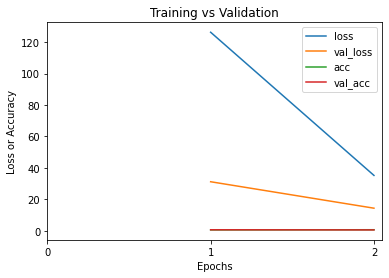

Training done in 3m 47s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2511      3
        -ve   2365    121
---------------------------------------------------
precision:0.5150, recall:0.9988
F1-score :0.6796
accuracy :0.5264
---------------------------------------------------
para/transformer_0.05_0.0003.pth -----------------------------------------------------------------
No of trainable parameters:  23804631
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [1/2], loss: 16.9754 - acc: 0.6719 - val_loss: 6.2162 - val_acc: 0.8074
Checkpoint Saved! Epoch 2 is better.***************************
Epoch [2/2], loss: 9.1468 - acc: 0.8035 - val_loss: 8.9180 - val_acc: 0.8224


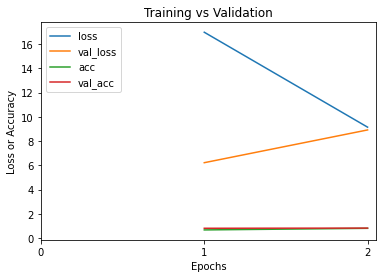

Training done in 3m 39s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2377    137
        -ve    751   1735
---------------------------------------------------
precision:0.7599, recall:0.9455
F1-score :0.8426
accuracy :0.8224
---------------------------------------------------
para/transformer_0.05_0.0001.pth -----------------------------------------------------------------
No of trainable parameters:  23804631
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [1/2], loss: 7.5524 - acc: 0.6253 - val_loss: 2.3466 - val_acc: 0.7492
Checkpoint Saved! Epoch 2 is better.***************************
Epoch [2/2], loss: 3.3361 - acc: 0.7837 - val_loss: 2.2363 - val_acc: 0.8222


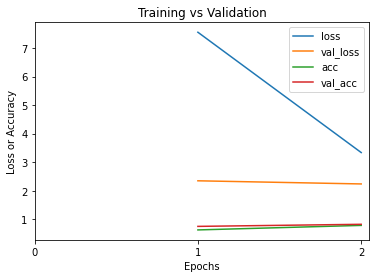

Training done in 3m 44s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   1916    598
        -ve    291   2195
---------------------------------------------------
precision:0.8681, recall:0.7621
F1-score :0.8117
accuracy :0.8222
---------------------------------------------------
para/transformer_0.05_3e-05.pth -----------------------------------------------------------------
No of trainable parameters:  23804631
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [1/2], loss: 7.5173 - acc: 0.6322 - val_loss: 3.0606 - val_acc: 0.7398
Checkpoint Saved! Epoch 2 is better.***************************
Epoch [2/2], loss: 2.1961 - acc: 0.7868 - val_loss: 1.6137 - val_acc: 0.7900


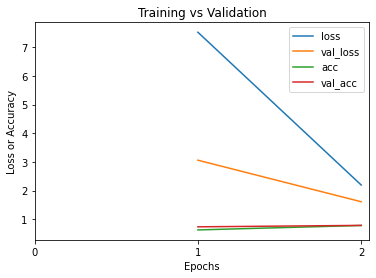

Training done in 3m 42s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   1946    568
        -ve    482   2004
---------------------------------------------------
precision:0.8015, recall:0.7741
F1-score :0.7875
accuracy :0.7900
---------------------------------------------------
para/transformer_0.1_0.001.pth -----------------------------------------------------------------
No of trainable parameters:  23804631
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [1/2], loss: 79.7141 - acc: 0.6243 - val_loss: 23.0066 - val_acc: 0.7854
Checkpoint Saved! Epoch 2 is better.***************************
Epoch [2/2], loss: 20.4984 - acc: 0.7240 - val_loss: 1.6600 - val_acc: 0.8202


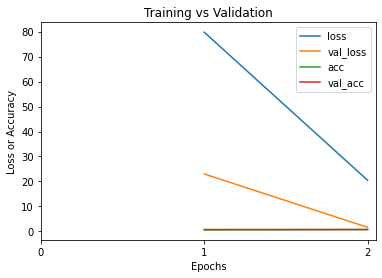

Training done in 3m 40s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2010    504
        -ve    395   2091
---------------------------------------------------
precision:0.8358, recall:0.7995
F1-score :0.8172
accuracy :0.8202
---------------------------------------------------
para/transformer_0.1_0.0003.pth -----------------------------------------------------------------
No of trainable parameters:  23804631
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [1/2], loss: 20.5281 - acc: 0.6773 - val_loss: 8.7981 - val_acc: 0.8260
early stop at epoch 2oss: 6.8370 - acc: 0.92000


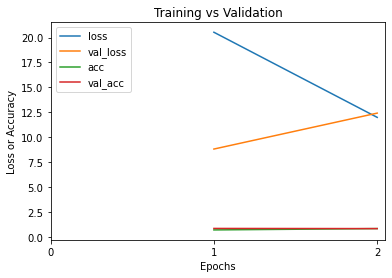

Training done in 3m 39s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   1686    828
        -ve    125   2361
---------------------------------------------------
precision:0.9310, recall:0.6706
F1-score :0.7797
accuracy :0.8094
---------------------------------------------------
para/transformer_0.1_0.0001.pth -----------------------------------------------------------------
No of trainable parameters:  23804631
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [1/2], loss: 8.8202 - acc: 0.6334 - val_loss: 3.5020 - val_acc: 0.7608
Checkpoint Saved! Epoch 2 is better.***************************
Epoch [2/2], loss: 4.7027 - acc: 0.7837 - val_loss: 3.2704 - val_acc: 0.8282


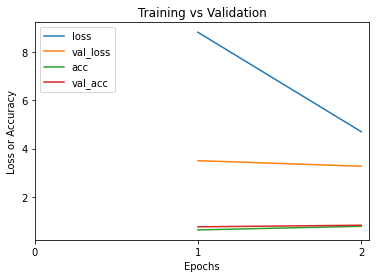

Training done in 3m 42s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   1914    600
        -ve    259   2227
---------------------------------------------------
precision:0.8808, recall:0.7613
F1-score :0.8167
accuracy :0.8282
---------------------------------------------------
para/transformer_0.1_3e-05.pth -----------------------------------------------------------------
No of trainable parameters:  23804631
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [1/2], loss: 8.2057 - acc: 0.6167 - val_loss: 5.6131 - val_acc: 0.6838
Checkpoint Saved! Epoch 2 is better.***************************
Epoch [2/2], loss: 3.5053 - acc: 0.7679 - val_loss: 3.5710 - val_acc: 0.7530


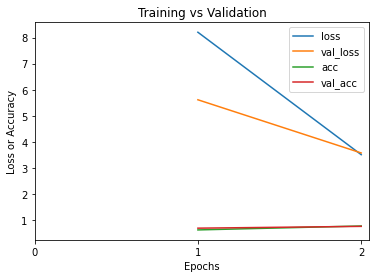

Training done in 3m 40s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2289    225
        -ve   1010   1476
---------------------------------------------------
precision:0.6938, recall:0.9105
F1-score :0.7875
accuracy :0.7530
---------------------------------------------------
para/transformer_0.15_0.001.pth -----------------------------------------------------------------
No of trainable parameters:  23804631
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [1/2], loss: 107.5316 - acc: 0.5195 - val_loss: 66.7913 - val_acc: 0.5210
early stop at epoch 2oss: 7.8604 - acc: 0.64000


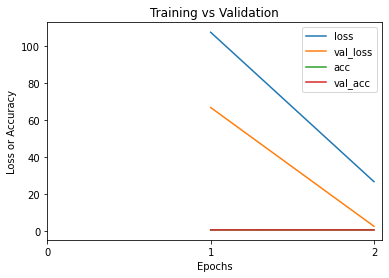

Training done in 3m 41s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve    143   2371
        -ve     35   2451
---------------------------------------------------
precision:0.8034, recall:0.0569
F1-score :0.1062
accuracy :0.5188
---------------------------------------------------
para/transformer_0.15_0.0003.pth -----------------------------------------------------------------
No of trainable parameters:  23804631
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [1/2], loss: 21.0863 - acc: 0.6713 - val_loss: 10.4489 - val_acc: 0.8100
Checkpoint Saved! Epoch 2 is better.***************************
Epoch [2/2], loss: 15.1077 - acc: 0.7942 - val_loss: 8.7043 - val_acc: 0.8478


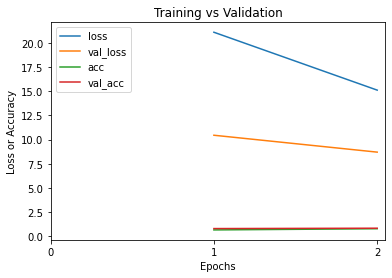

Training done in 3m 38s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2196    318
        -ve    443   2043
---------------------------------------------------
precision:0.8321, recall:0.8735
F1-score :0.8523
accuracy :0.8478
---------------------------------------------------
para/transformer_0.15_0.0001.pth -----------------------------------------------------------------
No of trainable parameters:  23804631
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [1/2], loss: 9.7062 - acc: 0.6248 - val_loss: 3.4167 - val_acc: 0.7756
Checkpoint Saved! Epoch 2 is better.***************************
Epoch [2/2], loss: 5.9938 - acc: 0.7706 - val_loss: 3.1280 - val_acc: 0.8364


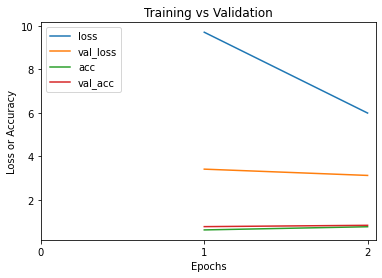

Training done in 3m 37s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2083    431
        -ve    387   2099
---------------------------------------------------
precision:0.8433, recall:0.8286
F1-score :0.8359
accuracy :0.8364
---------------------------------------------------
para/transformer_0.15_3e-05.pth -----------------------------------------------------------------
No of trainable parameters:  23804631
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [1/2], loss: 7.7915 - acc: 0.6249 - val_loss: 4.0677 - val_acc: 0.7314
early stop at epoch 2oss: 3.4256 - acc: 0.76000


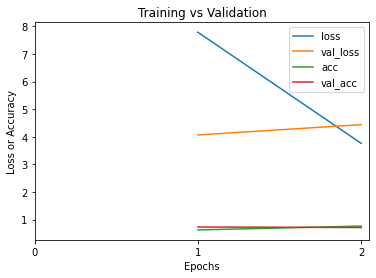

Training done in 4m 13s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   1244   1270
        -ve    171   2315
---------------------------------------------------
precision:0.8792, recall:0.4948
F1-score :0.6332
accuracy :0.7118
---------------------------------------------------
para/transformer_2_0.001.pth -----------------------------------------------------------------


ValueError: dropout probability has to be between 0 and 1, but got 2

In [27]:
# Transformer tuning

NUM_EPOCHS = 2
name_tuning = 't-drp-lr'

EMBED_SIZE = 256
num_heads=4
hidden_dim = 256
n_layers = 2

best_acc=0
for i in [0.05, 0.1, 0.15]:
    for j in [1e-3, 3e-4, 1e-4, 3e-5]:
        dropout, LR = i, j              #_____________change the variable name to suit needs
        
        CHECKPOINT_PATH = 'para/'+name_tuning+'_'+str(i)+'_'+str(j)+'.pth'
        print(CHECKPOINT_PATH,'-----------------------------------------------------------------')
        model = Transformer(vocab_size, EMBED_SIZE, num_heads, hidden_dim, n_layers, MAX_LEN, dropout).to(device)
        loss_fn = nn.BCEWithLogitsLoss().to(device)   #####  Diff from attention model
        optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.7, 0.99))
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
        print('No of trainable parameters: ', para_num(model))
        randomize()
        history = train(model, train_dl, valid_dl, loss_fn, optimizer, NUM_EPOCHS, accuracy, device, CHECKPOINT_PATH, scheduler, binaryloss=True, early_stop=True)
        confusion_m, acc, precision, recall = performance(model, valid_dl, binaryloss=True)
        if acc > best_acc:
            best_acc = acc
            best_hyper1 = i
            best_hyper2 = j
print('--------<<<-------best accuracy: {:.4f}, best hyperparameters:{}, {} -------->>>--------'.format(best_acc, best_hyper1, best_hyper2))

No of trainable parameters:  21284031
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [1/5], loss: 12.9991 - acc: 0.6400 - val_loss: 4.0977 - val_acc: 0.7868
Checkpoint Saved! Epoch 2 is better.***************************
Epoch [2/5], loss: 7.4803 - acc: 0.7674 - val_loss: 4.1502 - val_acc: 0.8386
Epoch [3/5], loss: 6.2845 - acc: 0.8191 - val_loss: 9.1514 - val_acc: 0.8134
Checkpoint Saved! Epoch 4 is better.***************************
Epoch [4/5], loss: 5.3712 - acc: 0.8508 - val_loss: 5.8788 - val_acc: 0.8650
Epoch [5/5], loss: 4.4621 - acc: 0.8781 - val_loss: 5.8816 - val_acc: 0.8636


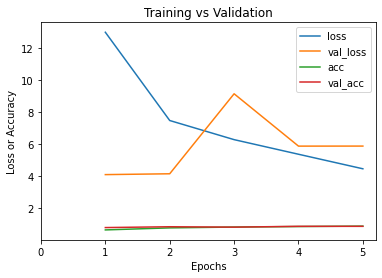

Training done in 7m 57s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2176    338
        -ve    344   2142
---------------------------------------------------
precision:0.8635, recall:0.8656
F1-score :0.8645
accuracy :0.8636
---------------------------------------------------
tensor([0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1],
       device='cuda:0')
tensor([-115.4083,  -81.0060,  -11.2738,  -98.7257,  106.2467,  136.4052,
         114.6797, -195.5614,   79.0439, -135.3645,  118.4510, -100.5237,
        -163.3451,  116.7595,  129.8436,  171.4897,   65.7118,  -83.3718,
        -102.8578,  174.4597], device='cuda:0')
tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1],
       device='cuda:0')


In [28]:
# Transformer 3

NUM_EPOCHS = 5

EMBED_SIZE = 256   # embed_dim must be divisible by num_heads
num_heads = 4      # num of heads in (multi head) attention models
hidden_dim = 256
n_layers = 2
dropout = 0.25
LR = 1e-4

CHECKPOINT_PATH = 'para/transformer.pth'

model = Transformer(vocab_size, EMBED_SIZE, num_heads, hidden_dim, n_layers, MAX_LEN, dropout).to(device)
loss_fn = nn.BCEWithLogitsLoss().to(device)   #####  Diff from attention model
optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.7, 0.99))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
print('No of trainable parameters: ', para_num(model))

randomize()
history = train(model, train_dl, valid_dl, loss_fn, optimizer, NUM_EPOCHS, accuracy, device, CHECKPOINT_PATH, scheduler, binaryloss=True)


confusion_m, acc, precision, recall = performance(model, valid_dl, binaryloss=True)
pred_all, out_all, label_all = predict(model, valid_dl, binaryloss=True)
print(pred_all[0:20])
print(out_all[0:20])
print(label_all[0:20])

## Train

## Test

In [33]:
model.load_state_dict(torch.load(CHECKPOINT_PATH))

<All keys matched successfully>

In [34]:
evaluate(model, test_dl, loss_fn, accuracy, device)

(0.29374080657958984, 0.8809999999999991)

## Final model training and testing

## Generalization - Restaurant reviews

###  explore some wrong predictions...

In [51]:
config = {
    "LR": tune.sample_from(lambda spec: 10 ** (-10 * np.random.rand())),
    "dropout": tune.uniform(0.01, 0.99),
}

In [56]:
# Transformer 3

def train_transformer(config, model=None, checkpoint_dir=None):
    
    NUM_EPOCHS = 2   if not 'NUM_EPOCHS' in config else config['NUM_EPOCHS']
    
    # EMBED_SIZE must be divisible by num_heads
    EMBED_SIZE = 256  if not 'EMBED_SIZE' in config else config['EMBED_SIZE']
    num_heads = 4     if not 'num_heads' in config else config['num_heads']
    hidden_dim = 256  if not 'hidden_dim' in config else config['hidden_dim']
    n_layers = 2      if not 'n_layers' in config else config['n_layers']
    dropout = 0.25  if not 'dropout' in config else config['dropout']
    LR = 1e-4         if not 'LR' in config else config['LR']

    CHECKPOINT_PATH = 'para/transformer.pth'  if not 'CHECKPOINT_PATH' in config else config['CHECKPOINT_PATH']

    if model is None:
        model = Transformer(vocab_size, EMBED_SIZE, num_heads, hidden_dim, n_layers, MAX_LEN, dropout).to(device)
    loss_fn = nn.BCEWithLogitsLoss().to(device)   #####  Diff from attention model
    optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.7, 0.99))
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
    print('No of trainable parameters: ', para_num(model))

    randomize()
    if model is None:
        for i in range(NUM_EPOCHS):
            history = train(model, train_dl, valid_dl, loss_fn, optimizer, 1, accuracy, device, CHECKPOINT_PATH, scheduler, binaryloss=True, print_step=False)
            tune.report(mean_accuracy=history['val_acc'])
    else:
        history = train(model, train_dl, valid_dl, loss_fn, optimizer, NUM_EPOCHS, accuracy, device, CHECKPOINT_PATH, scheduler, binaryloss=True, print_step=True)

    confusion_m, acc, precision, recall = performance(model, valid_dl, binaryloss=True)

In [53]:
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune import JupyterNotebookReporter, CLIReporter, ProgressReporter

#initialize ray, enable distributive exeucution
ray.init(ignore_reinit_error=True, address="auto")
reporter = JupyterNotebookReporter(overwrite=False, max_report_frequency=900)

2022-05-04 05:31:41,890	INFO worker.py:946 -- Connecting to existing Ray cluster at address: 10.10.4.4:6379
2022-05-04 05:31:41,891	INFO worker.py:963 -- Calling ray.init() again after it has already been called.


In [54]:
analysis = tune.run(
    train_transformer,
    num_samples=2,
    scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    progress_reporter=reporter,
    verbose=1,
    config=config,
    resources_per_trial={'gpu': 1}
)

2022-05-04 05:31:46,710	INFO trial_runner.py:803 -- starting train_transformer_1a138_00000
2022-05-04 05:31:47,983	WARNING worker.py:1382 -- Warning: The actor ImplicitFunc is very large (79 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2022-05-04 05:31:48,642	WARNING util.py:171 -- The `start_trial` operation took 1.931 s, which may be a performance bottleneck.


(train_transformer pid=8067) No of trainable parameters:  21284031


2022-05-04 05:33:35,162	ERROR trial_runner.py:876 -- Trial train_transformer_1a138_00000: Error processing event.
NoneType: None
(train_transformer pid=8067) 2022-05-04 05:33:35,076	ERROR function_runner.py:281 -- Runner Thread raised error.
(train_transformer pid=8067) Traceback (most recent call last):
(train_transformer pid=8067)   File "/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/ray/tune/function_runner.py", line 272, in run
(train_transformer pid=8067)     self._entrypoint()
(train_transformer pid=8067)   File "/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/ray/tune/function_runner.py", line 348, in entrypoint
(train_transformer pid=8067)     return self._trainable_func(
(train_transformer pid=8067)   File "/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/ray/util/tracing/tracing_helper.py", line 462, in _resume_span
(train_transformer pid=8067)     return method(self, *_args, **_kwargs)
(train_transformer pid=8067)   File "/opt/ap

(train_transformer pid=8175) No of trainable parameters:  21284031


(train_transformer pid=8175) 2022-05-04 05:35:23,142	ERROR function_runner.py:281 -- Runner Thread raised error.
(train_transformer pid=8175) Traceback (most recent call last):
(train_transformer pid=8175)   File "/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/ray/tune/function_runner.py", line 272, in run
(train_transformer pid=8175)     self._entrypoint()
(train_transformer pid=8175)   File "/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/ray/tune/function_runner.py", line 348, in entrypoint
(train_transformer pid=8175)     return self._trainable_func(
(train_transformer pid=8175)   File "/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/ray/util/tracing/tracing_helper.py", line 462, in _resume_span
(train_transformer pid=8175)     return method(self, *_args, **_kwargs)
(train_transformer pid=8175)   File "/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/ray/tune/function_runner.py", line 640, in _trainable_func
(train_transfo

Trial name,# failures,error file
train_transformer_1a138_00000,1,"/users/adcm168/ray_results/train_transformer_2022-05-04_05-31-44/train_transformer_1a138_00000_0_LR=4.7924e-05,drop_prob=0.2954_2022-05-04_05-31-46/error.txt"
train_transformer_1a138_00001,1,"/users/adcm168/ray_results/train_transformer_2022-05-04_05-31-44/train_transformer_1a138_00001_1_LR=0.040277,drop_prob=0.2963_2022-05-04_05-33-35/error.txt"


TuneError: ('Trials did not complete', [train_transformer_1a138_00000, train_transformer_1a138_00001])

In [ ]:
# plot
dfs = analysis.trial_dataframes
[d.mean_accuracy.plot() for d in dfs.values()]
# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)

In [ ]:
print("Best hyperparameters found were: ", analysis.best_config)

In [ ]:
#evaluate and load

df = analysis.results_df
logdir = analysis.get_best_logdir("mean_accuracy", mode="max")
state_dict = torch.load(os.path.join(logdir, "model.pth"))

model_t = Transformer(vocab_size, EMBED_SIZE, num_heads, hidden_dim, n_layers, MAX_LEN, dropout).to(device)
model_t.load_state_dict(state_dict)

In [ ]:
confusion_m, acc, precision, recall = performance(model_t, valid_dl, binaryloss=True)